In [1]:
# Read & update data from MongoDB
from pymongo import MongoClient
import numpy as np
from setting import DB_HOST, DB_PORT, DB_NAME

def get_fps(collection_name, find_opt = {'_id': 0, 'fingerprint': 1, 'coordinate': 1}):
    collection = MongoClient(DB_HOST, DB_PORT)[DB_NAME][collection_name]
    docs = list(collection.find({}, find_opt))

    docs.sort(key=lambda x: x['coordinate'])
    
    fps = np.array([doc['fingerprint'] for doc in docs])
    cordnts = np.array([doc['coordinate'] for doc in docs])
    
    return fps, cordnts

def update(where, update_query):
    #     where = {'coordinate': [100, 100]}
    #     update_query = {'$set': {'coordinate': [6, 30]}}

    collection = MongoClient(DB_HOST, DB_PORT)[DB_NAME]['testpoint_N1_7F_half(ss4)']
    collection.update_many(where, update_query)

In [2]:
# Train KNN
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

n_neighbors, num_fp = 3, 100


train_fps, train_cordnts = get_fps('radiomap_N1_7F_half(ss4)-v2')
train_fps, train_cordnts = train_fps[::3], train_cordnts[::3]
test_fps, test_cordnts = get_fps('testpoint_N1_7F_half(ss4)')

neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(train_fps, train_cordnts)

KNeighborsClassifier(n_neighbors=3)

In [3]:
# Predict test data
_, neigh_inds = neigh.kneighbors(test_fps)

err_lst = []

for cordnt, neigh_idx in zip(test_cordnts, neigh_inds):
    neigh_cordnt = train_cordnts[neigh_idx]    
    pred_cordnt = np.array([neigh_cordnt[:, 0].mean(), neigh_cordnt[:, 1].mean()])
    
    error = np.linalg.norm(pred_cordnt - cordnt)
    err_lst.append(error)
    
    print('neigh cordnt:', neigh_cordnt.tolist())
    print('pred_cordnt: {}\treal_cordnt: {}'.format(pred_cordnt, cordnt))
    print('error distance(m):', error)
    print()

err_lst = np.array(err_lst)

neigh cordnt: [[2, 14], [3, 14], [1, 14]]
pred_cordnt: [ 2. 14.]	real_cordnt: [ 4 14]
error distance(m): 2.0

neigh cordnt: [[2, 14], [3, 14], [1, 14]]
pred_cordnt: [ 2. 14.]	real_cordnt: [ 4 14]
error distance(m): 2.0

neigh cordnt: [[3, 14], [2, 14], [0, 17]]
pred_cordnt: [ 1.66666667 15.        ]	real_cordnt: [ 4 14]
error distance(m): 2.5385910352879693

neigh cordnt: [[2, 14], [3, 14], [1, 14]]
pred_cordnt: [ 2. 14.]	real_cordnt: [ 4 14]
error distance(m): 2.0

neigh cordnt: [[2, 14], [3, 14], [1, 14]]
pred_cordnt: [ 2. 14.]	real_cordnt: [ 4 14]
error distance(m): 2.0

neigh cordnt: [[3, 14], [2, 14], [0, 17]]
pred_cordnt: [ 1.66666667 15.        ]	real_cordnt: [ 4 14]
error distance(m): 2.5385910352879693

neigh cordnt: [[3, 14], [2, 14], [0, 17]]
pred_cordnt: [ 1.66666667 15.        ]	real_cordnt: [ 4 14]
error distance(m): 2.5385910352879693

neigh cordnt: [[2, 14], [3, 14], [1, 14]]
pred_cordnt: [ 2. 14.]	real_cordnt: [ 4 14]
error distance(m): 2.0

neigh cordnt: [[3, 14], [2,

In [4]:
# Accuracy(distance error)
def print_accu(name, errs):
    print('>>>' + name)
    print('mean:', errs.mean())
    print('standard deviation:', errs.std())
    print()


for idx, errs_at_point in enumerate(err_lst.reshape(-1, num_fp)):
    print_accu('Point {}'.format(idx + 1), errs_at_point)

print_accu('Total', err_lst)

>>>Point 1
mean: 1.9101167901482259
standard deviation: 0.5530807286809786

>>>Point 2
mean: 2.9866666666666664
standard deviation: 0.10456258094238752

>>>Point 3
mean: 3.1631759038880625
standard deviation: 1.7048578894688438

>>>Total
mean: 2.6866531202343187
standard deviation: 1.1752252000337895



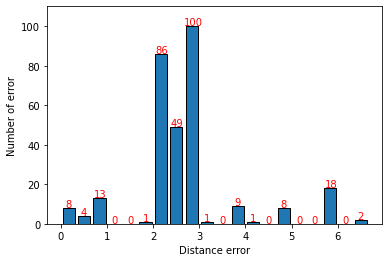

In [5]:
# Dinstance error histogram
import collections

err_counter = collections.Counter(err_lst)
err_cnt_item = sorted(err_counter.items(), key=lambda x:x[0])
x, y = [dist_err for dist_err, _ in err_cnt_item], [cnt for _, cnt in err_cnt_item]
x, y = np.array(x), np.array(y)


ys, xs, _ = plt.hist(x, bins = 20, weights = y, edgecolor='black', rwidth=0.8)
plt.xlabel('Distance error')
plt.ylabel('Number of error')
plt.ylim(0, max(ys) + 10)

for idx, yi in enumerate(ys):
    x_offset = {3: 0.,
                1: 0.1}.get(len(str(int(yi))), 0.05)
    plt.text(x=xs[idx] + x_offset, y=yi + 0.4,
            s=int(yi), color='red')

# plt.savefig('distance error histogram.png')

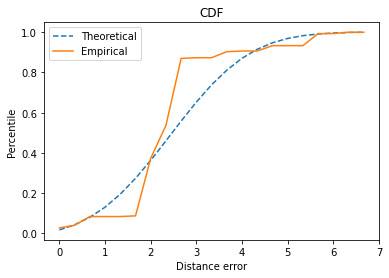

In [6]:
# CDF graph
th_y = ((1 / (np.sqrt(2 * np.pi) * x.std())) *
         np.exp(-0.5 * (1 / x.std() * (xs - x.mean())**2)))
th_cum_y = th_y.cumsum()
th_cum_y /= th_cum_y[-1]

em_cum_y = np.append(ys, np.zeros((1))).cumsum()
em_cum_y = em_cum_y / em_cum_y[-1]

plt.plot(xs, th_cum_y, label='Theoretical', linestyle = '--')
plt.plot(xs, em_cum_y, label='Empirical')
plt.xlabel('Distance error')
plt.ylabel('Percentile')
plt.title('CDF')
plt.legend()

# plt.savefig('CDF.png')

In [7]:
# CDF graph - Percentile
def get_pcent():
    ############################################
    pcent_section = [0.50, 0.75, 0.90, 0.95, 1]
    ############################################
    for pcent in pcent_section:
        yield pcent

cum_y = y.cumsum()
cum_y = cum_y / cum_y[-1]

pcent_dic, gen = {int(pcent * 100): -1 for pcent in get_pcent()}, get_pcent()

pcent = next(gen)
for xi, yi in zip(x, cum_y):
    if yi >= pcent:
        pcent_dic[pcent] = round(xi, 2)
        try:
            pcent = next(gen)
        except:
            break

print(pcent_dic)
# To check error case
[(xi, yi) for xi, yi in zip(x, cum_y)]

{50: -1, 75: -1, 90: -1, 95: -1, 100: -1, 0.5: 2.54, 0.75: 3.0, 0.9: 3.73, 0.95: 5.67, 1: 6.67}


[(0.0, 0.0033333333333333335),
 (0.33333333333333304, 0.02666666666666667),
 (0.3333333333333335, 0.03333333333333333),
 (0.4714045207910322, 0.03666666666666667),
 (0.6666666666666661, 0.04),
 (0.7453559924999289, 0.07666666666666666),
 (0.9428090415820638, 0.08333333333333333),
 (1.7950549357115013, 0.08666666666666667),
 (2.0, 0.3433333333333333),
 (2.1081851067789192, 0.37333333333333335),
 (2.426703296426838, 0.4866666666666667),
 (2.5385910352879693, 0.5333333333333333),
 (2.666666666666666, 0.5366666666666666),
 (2.748737083745108, 0.54),
 (3.0, 0.87),
 (3.333333333333332, 0.8733333333333333),
 (3.7267799624996507, 0.9033333333333333),
 (4.0, 0.9066666666666666),
 (5.0, 0.9333333333333333),
 (5.666666666666668, 0.99),
 (6.0, 0.9933333333333333),
 (6.666666666666668, 1.0)]